<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Recomendando Música

El objetivo de este caso-taller es construir un sistema de recomendación de Música utilizando los datos de [Last.fm](https://www.last.fm/) provistos  abiertamente por [grouplens](https://grouplens.org/about/what-is-grouplens/) para: **"avanzar la teoría y la práctica de la computación social mediante la construcción y la comprensión de sistemas *(de recomendación)* utilizados por personas reales".**

Los datos contienen información sobre artistas, usuarios, y las veces que estos escucharon sus canciones. Las bases se encuentran en los `Archivos de Laboratorio` en la carpeta `data`, allí también está disponible un archivo [README](data/readme.txt) que contiene más información sobre las bases.


## Instrucciones generales

1. Para desarrollar el *cuaderno*, primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "Revisión por el compañero".

4. El archivo entregado debe poder ser ejecutado localmente por los pares. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos 

En la carpeta `data` se encuentran los archivos:

   - `artists.dat`  que contienen el identificador del artista (`id`), nombre (`name`), link a la página del artista en last.fm (`url`), y link a la imagen del usuario (`pictureURL`), vale aclarar que varios de estos links están rotos. 
   - `user_artists.dat`  que contiene identificador del usuario (`userID`), nombre del artista que escuchó (`artistID`), y las veces que los escuchó (`weight`).

Cargue estos datos en su *cuaderno*:

   1. Para la base de artistas seleccione las columnas de identificador de artista (`id`) y nombre (`name`). Renombre estas columnas para poder hacer la unión con la base `user_artists.dat`.
   2. Para la base de usuarios y artistas, renombre las columnas de forma tal que se mantenga la consistencia para unir con la base anterior, y renombre la columna `weight` a `nro_reproducciones`.
   3. Una estas bases.
   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Utilice este espacio para escribir el código.
dir_artist = "data/artists.dat"
dir_listenings = "data/user_artists.dat"
artist_df = pd.read_csv(dir_artist, delimiter='\t')
listenings_df = pd.read_csv(dir_listenings, delimiter='\t')

print("numero de regsitros en artistas: {}".format(artist_df.shape[0]))
print("numero de regsitros en listenings: {}".format(listenings_df.shape[0]))

numero de regsitros en artistas: 17632
numero de regsitros en listenings: 92834


In [3]:
base_df = pd.merge(listenings_df,artist_df.rename(columns={"id":"artistID"})[["artistID","name"]], on ="artistID")
base_df.rename(columns = {"weight":"nro_reproducciones"}, inplace=True)
base_df

,userID,artistID,nro_reproducciones,name
0,2,51,13883,Duran Duran
1,2,52,11690,Morcheeba
2,2,53,11351,Air
3,2,54,10300,Hooverphonic
4,2,55,8983,Kylie Minogue
...,...,...,...,...
92829,2100,18726,337,Nyktalgia
92830,2100,18727,297,Atsakau niekadA
92831,2100,18728,281,Domantas Razauskas
92832,2100,18729,280,Atalyja


In [4]:
base_df.isna().sum()

userID                0
artistID              0
nro_reproducciones    0
name                  0
dtype: int64

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

### 2. Análisis preliminar. 

En esta sección exploraremos la base. Para ello responda las siguientes preguntas.

#### 2.1 ¿Cuantos usuarios y artistas hay en la base?


In [5]:
n_artistas = len(base_df["artistID"].unique())
n_users = len(base_df["userID"].unique())

print("cantidad de usuarios: {}".format(n_users))
print("cantidad de artistas: {}".format(n_artistas))
print("numero promedio de artistas escuchados por usuario: {}".format(np.round(n_artistas/n_users),0))

cantidad de usuarios: 1892
cantidad de artistas: 17632
numero promedio de artistas escuchados por usuario: 9.0



#### 2.2 ¿Cuáles es la distribución de probabilidad del consumo por artista? (haga el calculo sin ponderar y ponderando por el numero de reproducciones) ¿Qué podemos inferir a partir de la comparación de ambas?

In [6]:
base_probas = base_df.groupby(["artistID","name"]).agg({"userID":"count", "nro_reproducciones":"sum"}).reset_index()
base_probas.rename(columns={"userID":"num_personas"}, inplace=True)
base_probas["proba_personas"] = base_probas["num_personas"]/base_probas["num_personas"].sum()

base_probas["proba_reproducciones"] = base_probas["nro_reproducciones"]/base_probas["nro_reproducciones"].sum()
base_probas["proba_personas_ponderado"] = base_probas["num_personas"]*base_probas["proba_reproducciones"]
base_probas["proba_personas_ponderado"] = base_probas["proba_personas_ponderado"]/base_probas["proba_personas_ponderado"].sum()


base_probas["rank_num_personas"] = base_probas["proba_personas"].rank(method="min", ascending=False)
base_probas["rank_ponderado"] = base_probas["proba_personas_ponderado"].rank(method="min", ascending=False)

base_probas["diff_ranks"] = base_probas["rank_num_personas"] - base_probas["rank_ponderado"]
base_probas

,artistID,name,num_personas,nro_reproducciones,proba_personas,proba_reproducciones,proba_personas_ponderado,rank_num_personas,rank_ponderado,diff_ranks
0,1,MALICE MIZER,3,771,0.000032,0.000011,2.227592e-07,3522.0,4771.0,-1249.0
1,2,Diary of Dreams,12,8012,0.000129,0.000116,9.259386e-06,1212.0,1129.0,83.0
2,3,Carpathian Forest,3,775,0.000032,0.000011,2.239149e-07,3522.0,4759.0,-1237.0
3,4,Moi dix Mois,2,563,0.000022,0.000008,1.084422e-07,4615.0,6174.0,-1559.0
4,5,Bella Morte,2,913,0.000022,0.000013,1.758575e-07,4615.0,5205.0,-590.0
...,...,...,...,...,...,...,...,...,...,...
17627,18741,Diamanda Galás,1,301,0.000011,0.000004,2.898855e-08,6954.0,9982.0,-3028.0
17628,18742,Aya RL,1,294,0.000011,0.000004,2.831440e-08,6954.0,10073.0,-3119.0
17629,18743,Coptic Rain,1,287,0.000011,0.000004,2.764025e-08,6954.0,10162.0,-3208.0
17630,18744,Oz Alchemist,1,286,0.000011,0.000004,2.754394e-08,6954.0,10174.0,-3220.0


Text(0.5, 1.0, 'Cambio en posiciones con la ponderacion')

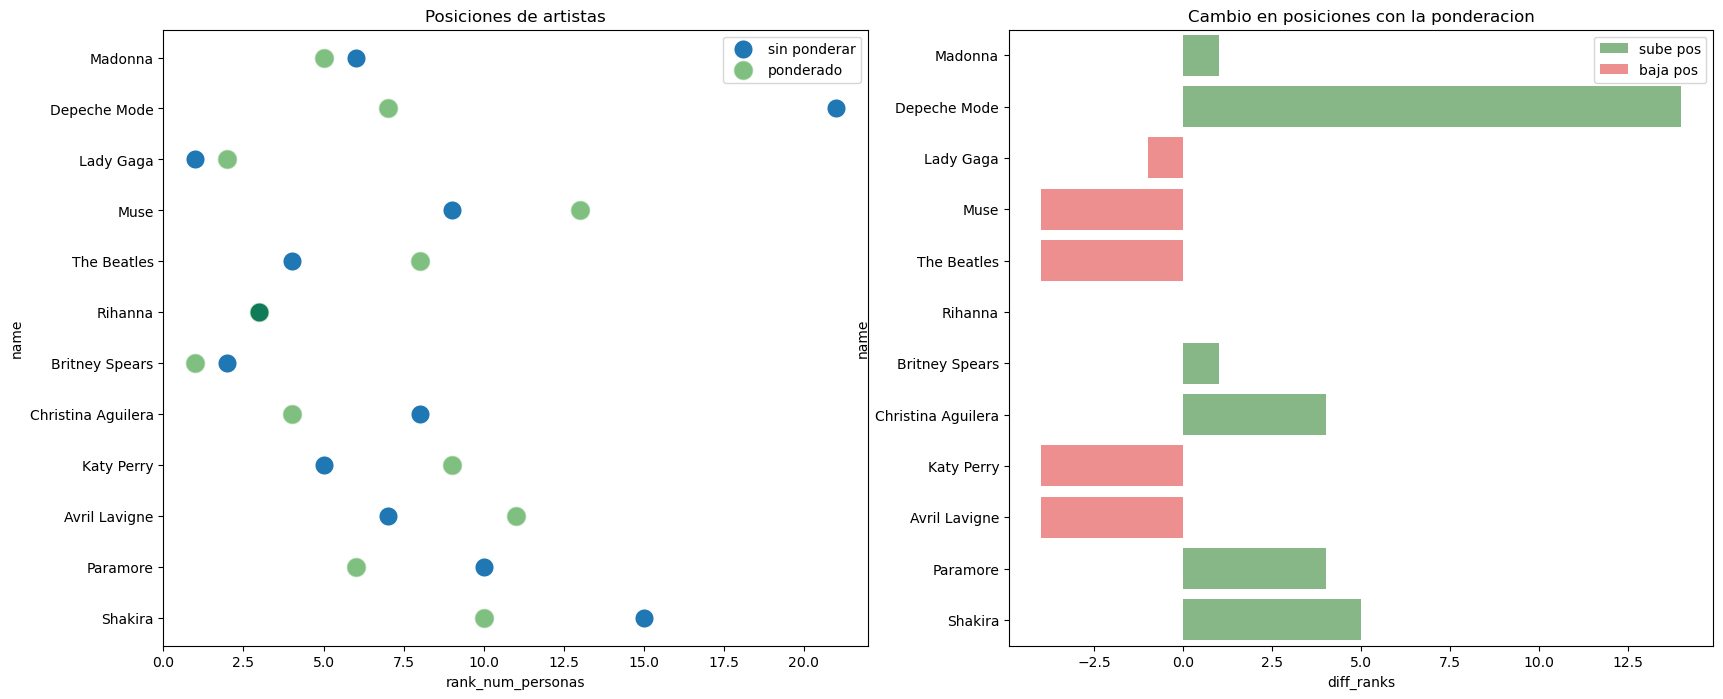

In [7]:
c_rank_personas = base_probas["rank_num_personas"] <= 10
c_rank_ponderado = base_probas["rank_ponderado"] <= 10

data = base_probas[c_rank_personas|c_rank_ponderado]

fig, ax = plt.subplots(1,2,figsize = (20,8))
axs=ax.flatten()

sns.scatterplot(data=data, y="name", x="rank_num_personas", ax=ax[0], s=200, label="sin ponderar")
sns.scatterplot(data=data, y="name", x="rank_ponderado", ax=ax[0], color="g", s=200, alpha=0.5, label="ponderado")
ax[0].set_title("Posiciones de artistas")
c = data["diff_ranks"] >= 0
sns.barplot(data=data, y="name", x="diff_ranks", color="white", alpha=1, ax=ax[1])
sns.barplot(data=data[c], y="name", x="diff_ranks", color="g", alpha=0.5, ax=ax[1],label="sube pos")
sns.barplot(data=data[~c], y="name", x="diff_ranks", color="r", alpha=0.5, ax=ax[1],label="baja pos")
ax[1].set_title("Cambio en posiciones con la ponderacion")

In [8]:
c_rank_personas = base_probas["rank_num_personas"] <= 10
c_rank_ponderado = base_probas["rank_ponderado"] <= 10

result_rank = pd.merge(base_probas.loc[c_rank_personas,["name","rank_num_personas"]] , base_probas.loc[c_rank_ponderado,["name","rank_ponderado"]], 
                       left_on="rank_num_personas", right_on="rank_ponderado")\
                .sort_values(by="rank_num_personas").reset_index()

result_rank.rename(columns={"name_x":"artista_no_ponderado","name_y":"artista_ponderado"},inplace = True)
result_rank[["artista_no_ponderado","artista_ponderado"]]

,artista_no_ponderado,artista_ponderado
0,Lady Gaga,Britney Spears
1,Britney Spears,Lady Gaga
2,Rihanna,Rihanna
3,The Beatles,Christina Aguilera
4,Katy Perry,Madonna
5,Madonna,Paramore
6,Avril Lavigne,Depeche Mode
7,Christina Aguilera,The Beatles
8,Muse,Katy Perry
9,Paramore,Shakira


Las posciiones de los artistas mas populares cambian dependiendo de si se tienen en cuenta el numero de reproducciones o no, lo que hace evidente la importancia de la seleccion de la metrica de probabilidad utilizada.

#### 2.3 Para el usuario 8 (`userID==8`) ¿cuál es la distribución de reproducción de artistas basado en el número de reproducciones relativas?. Presente sus resultados usando tablas y/o gráficas. ¿Encuentra algún patrón en los artistas que escucha y las veces que reproduce? ¿Podemos decir algo de sus preferencias?


In [9]:
c_user_8 = base_df["userID"] == 8

base_probas_user8 = base_df[c_user_8].groupby(["artistID","name"]).agg({"nro_reproducciones":"sum"}).reset_index()

base_probas_user8["proba_reproducciones"] = base_probas_user8["nro_reproducciones"]/base_probas_user8["nro_reproducciones"].sum()
base_probas_user8["rank_num_reproducciones"] = base_probas_user8["proba_reproducciones"].rank(method="min", ascending=False)


base_probas_user8.sort_values(by="proba_reproducciones", ascending=False)

,artistID,name,nro_reproducciones,proba_reproducciones,rank_num_reproducciones
17,334,No Angels,6291,0.173406,1.0
18,335,Sandy,2396,0.066044,2.0
7,289,Britney Spears,2258,0.062240,3.0
19,336,Vanessa Petruo,1735,0.047824,4.0
10,295,Beyoncé,1425,0.039279,5.0
20,337,Alexander,1407,0.038783,6.0
11,296,Sugababes,1039,0.028639,7.0
21,338,Queensberry,963,0.026544,8.0
1,89,Lady Gaga,921,0.025387,9.0
22,339,Fady Maalouf,819,0.022575,10.0


,artistID,name,nro_reproducciones,proba_reproducciones,rank_num_reproducciones,rank_ponderado,diff_user8
17,334,No Angels,6291,0.173406,1.0,1571.0,-1570.0
18,335,Sandy,2396,0.066044,2.0,3527.0,-3525.0
7,289,Britney Spears,2258,0.062240,3.0,1.0,2.0
19,336,Vanessa Petruo,1735,0.047824,4.0,5312.0,-5308.0
10,295,Beyoncé,1425,0.039279,5.0,12.0,-7.0
20,337,Alexander,1407,0.038783,6.0,5686.0,-5680.0
11,296,Sugababes,1039,0.028639,7.0,167.0,-160.0
21,338,Queensberry,963,0.026544,8.0,4769.0,-4761.0
1,89,Lady Gaga,921,0.025387,9.0,2.0,7.0
22,339,Fady Maalouf,819,0.022575,10.0,6906.0,-6896.0


<Axes: xlabel='nro_reproducciones', ylabel='name'>

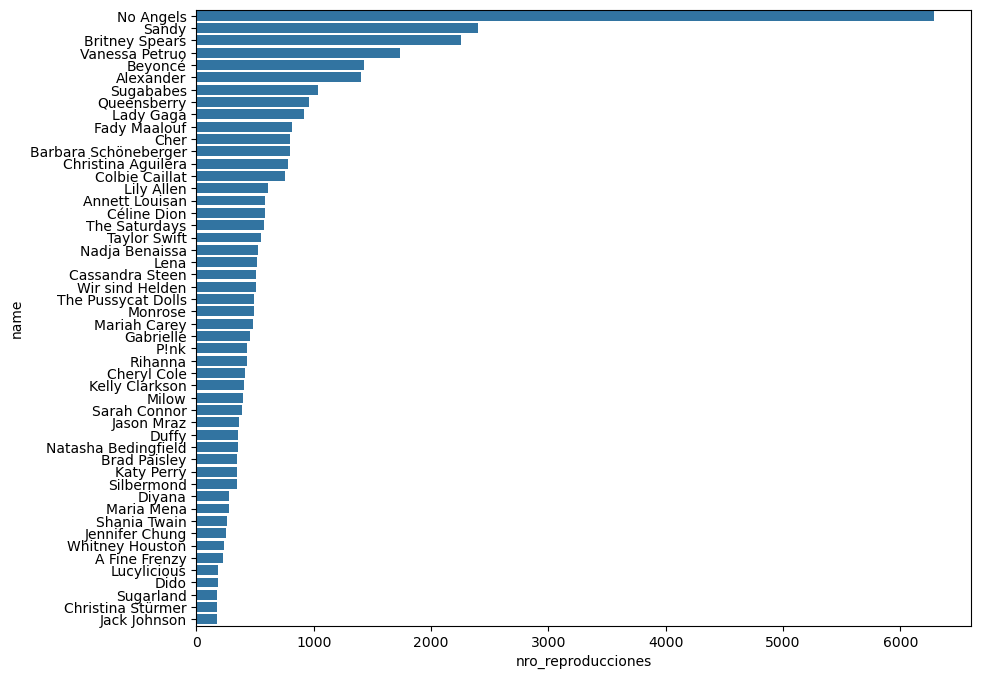

In [10]:
base_probas_user8 = pd.merge(base_probas_user8, base_probas.loc[:,["artistID","rank_ponderado"]], how="left", on="artistID")
base_probas_user8["diff_user8"] = base_probas_user8["rank_num_reproducciones"] - base_probas_user8["rank_ponderado"]
base_probas_user8 = base_probas_user8.sort_values(by="rank_num_reproducciones",ascending=True)

display(base_probas_user8.head(10))

fig,ax = plt.subplots(figsize=(10,8))
sns.barplot(data=base_probas_user8, y="name",x="nro_reproducciones")

Text(0.5, 1.0, 'Cambio en posiciones con la ponderacion')

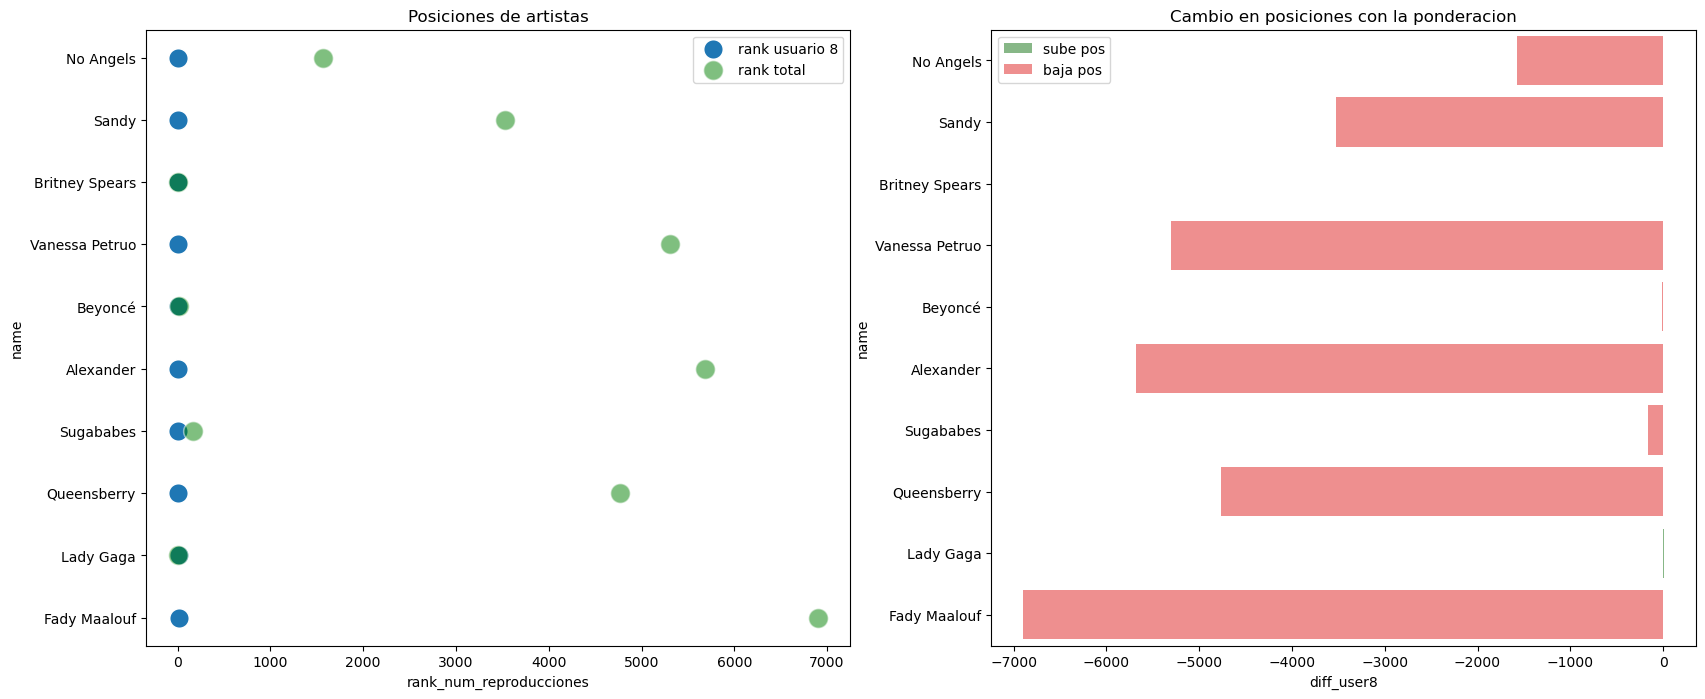

In [11]:
data = base_probas_user8.sort_values(by="rank_num_reproducciones",ascending=True).head(10)

fig, ax = plt.subplots(1,2,figsize = (20,8))
axs=ax.flatten()

sns.scatterplot(data=data, y="name", x="rank_num_reproducciones", ax=ax[0], s=200, label="rank usuario 8")
sns.scatterplot(data=data, y="name", x="rank_ponderado", ax=ax[0], color="g", s=200, alpha=0.5, label="rank total")
ax[0].set_title("Posiciones de artistas")
c = data["diff_user8"] >= 0
sns.barplot(data=data, y="name", x="diff_user8", color="white", alpha=1, ax=ax[1])
sns.barplot(data=data[c], y="name", x="diff_user8", color="g", alpha=0.5, ax=ax[1],label="sube pos")
sns.barplot(data=data[~c], y="name", x="diff_user8", color="r", alpha=0.5, ax=ax[1],label="baja pos")
ax[1].set_title("Cambio en posiciones con la ponderacion")

In [12]:
prom_reporudcciones_user8 = base_probas_user8.sort_values(by="proba_reproducciones", ascending=False).head(10)[["nro_reproducciones"]].mean()

percentil75_reproducciones_total = base_probas["nro_reproducciones"].quantile(0.75)

print("el promedio de escucha del usuario8 en su top 10 de artistas es: {}".format(prom_reporudcciones_user8.values[0]))
print("Percentil 75 de escucha total: {}".format(percentil75_reproducciones_total))

el promedio de escucha del usuario8 en su top 10 de artistas es: 1925.4
Percentil 75 de escucha total: 1234.25


los artistas escuchados por el **usuario 8** son distintos a los populares, sus artistas preferidos estan en "lejos" en el ranking de popularidad global, por lo que el comportamiento de escucha de este usuario es singluar y es distinto de la cultura **POP**, Adicionalmente se ve que esta persona tiene preferencia por las artistas o bandas femeninas.

Finbalmente el promedio de escucha de los artistas favoritos de este usuario esta por encima del percentil 75 de toda la base lo cual indica que es una persona con una escucha activa en la escucha de sus artistas

### 3. Generando Recomendaciones

En esta sección nos interesa generar recomendaciones ***nuevas y relevantes*** para el usuario 8 (`userID==8`). Para ello vamos a generar distintos sistemas de recomendación y comparar las recomendaciones generadas.

#### 3.1. Filtrado colaborativo sencillo: promedios simples.

Usando el promedio simple basado en el número de usuarios que escucha un artista (sin considerar el número de veces que estos usuarios reproducen al artista) genere una tabla y/o gráfica con 10 recomendaciones de artistas para este usuario. Explique con cuidado su procedimiento y justifique sus elecciones.

In [13]:
# Utilice este espacio para escribir el código.

artistas_user8 = np.array(base_probas_user8["artistID"])
artistas_user8

c = base_probas["artistID"].isin(artistas_user8)

base_probas[~c].sort_values(by = "num_personas",ascending = False).head(10)[["name","rank_num_personas"]]

,name,rank_num_personas
221,The Beatles,4.0
61,Madonna,6.0
327,Avril Lavigne,7.0
184,Muse,9.0
492,Paramore,10.0
148,Radiohead,12.0
59,Coldplay,13.0
460,Ke$ha,14.0
695,Shakira,15.0
300,Black Eyed Peas,17.0


Para la sugerencia se deben excluir los artistas que el usuario 8 ya escucha, una vez eliminados se procesde a obtener los 10 artistas que tengan  la mayor cantidad de personas que los escuchan. Este metodo si bien puede tener algunos artistas que quizas sean buenas sugerencias, no tiene en cuenta las particularidades de cada usuario y sus preferencias y solo da lo que es mas popular para toda la poblacion

#### 3.2.  Filtrado colaborativo sencillo: promedios ponderados.

Utilice un promedio ponderado para generar las recomendaciones. Considere el número de veces que los usuarios reproducen al artista. En otras palabras, genere un ponderador que use el número de veces que el artista fue reproducido (`nro_reproducciones`). Este método pondera la popularidad de un artista, combinando el número de usuarios que lo escuchan con la frecuencia de reproducción, de manera que los artistas con más reproducciones reciban una mayor ponderación.

Genere una tabla y/o gráfica con las 10 principales recomendaciones de artistas para este usuario. Explique detalladamente su procedimiento y justifique sus elecciones. Compare estas recomendaciones con las del sistema implementado en el paso anterior.

In [14]:
artistas_user8 = np.array(base_probas_user8["artistID"])
artistas_user8

c = base_probas["artistID"].isin(artistas_user8)

base_probas[~c].sort_values(by = "rank_ponderado",ascending = True).head(10)[["name","rank_ponderado"]]

,name,rank_ponderado
61,Madonna,5.0
492,Paramore,6.0
66,Depeche Mode,7.0
221,The Beatles,8.0
695,Shakira,10.0
327,Avril Lavigne,11.0
184,Muse,13.0
148,Radiohead,14.0
455,Miley Cyrus,15.0
460,Ke$ha,16.0


(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 3.3.  Filtrado colaborativo sencillo: similitud de coseno.

Usando el promedio ponderado de reproducciones genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario. Para generar los pesos utilice la distancia de coseno. Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en el paso anterior.

In [16]:
# Utilice este espacio para escribir el código.

#base_df_sim_coseno = pd.merge(base_df,base_probas[["artistID","proba_personas_ponderado"]], on = "artistID")
#base_df_sim_coseno["proba_ponderado_user"] = base_df_sim_coseno["nro_reproducciones"] * base_df_sim_coseno["proba_personas_ponderado"]

base_df_sim_coseno = base_df.copy()
base_df_sim_coseno["proba_ponderado_user"] = base_df_sim_coseno["nro_reproducciones"]/ base_df_sim_coseno.groupby("userID")["nro_reproducciones"].transform("sum")
base_df_sim_coseno

,userID,artistID,nro_reproducciones,name,proba_ponderado_user
0,2,51,13883,Duran Duran,0.082276
1,2,52,11690,Morcheeba,0.069279
2,2,53,11351,Air,0.067270
3,2,54,10300,Hooverphonic,0.061042
4,2,55,8983,Kylie Minogue,0.053237
...,...,...,...,...,...
92829,2100,18726,337,Nyktalgia,0.010914
92830,2100,18727,297,Atsakau niekadA,0.009619
92831,2100,18728,281,Domantas Razauskas,0.009101
92832,2100,18729,280,Atalyja,0.009068


In [101]:
#matrix_base_sim_coseno = base_df_sim_coseno.pivot_table(values='proba_ponderado_user', index='userID', columns='artistID')
matrix_base_sim_coseno = base_df_sim_coseno.pivot_table(values='nro_reproducciones', index='userID', columns='artistID')

matrix_base_sim_coseno_fillna = matrix_base_sim_coseno.fillna(0)

In [102]:
#Calculamos la similitud de coseno 
cosine_sim = cosine_similarity(matrix_base_sim_coseno_fillna, matrix_base_sim_coseno_fillna)

# Transformamos la matriz resultante en un dataframe
cosine_sim = pd.DataFrame(cosine_sim, index=matrix_base_sim_coseno_fillna.index, columns=matrix_base_sim_coseno_fillna.index)

cosine_sim.head(10)

userID,2,3,4,5,6,7,8,9,10,11,...,2090,2091,2092,2093,2094,2095,2096,2097,2099,2100
userID,,,,,,,,,,,,,,,,,,,,,
2,1.000000,0.0,0.144786,0.028692,0.007016,0.030219,0.008964,0.0,0.000000,0.021267,...,0.000000,0.043405,0.000000,0.004625,0.001585,0.0,0.000956,0.082134,0.000000,0.0
3,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000318,0.0
4,0.144786,0.0,1.000000,0.081193,0.006609,0.000000,0.000000,0.0,0.009072,0.013407,...,0.000000,0.000000,0.003776,0.006178,0.000000,0.0,0.045125,0.659085,0.000000,0.0
5,0.028692,0.0,0.081193,1.000000,0.000000,0.000000,0.000000,0.0,0.169078,0.004639,...,0.010993,0.000000,0.205141,0.000000,0.000000,0.0,0.204557,0.119133,0.000000,0.0
6,0.007016,0.0,0.006609,0.000000,1.000000,0.012713,0.018881,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
7,0.030219,0.0,0.000000,0.000000,0.012713,1.000000,0.167416,0.0,0.000000,0.247062,...,0.000000,0.001678,0.000000,0.000000,0.017636,0.0,0.000000,0.000000,0.000000,0.0
8,0.008964,0.0,0.000000,0.000000,0.018881,0.167416,1.000000,0.0,0.000000,0.187304,...,0.000000,0.000000,0.000000,0.000000,0.034826,0.0,0.000000,0.000000,0.000000,0.0
9,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,...,0.048289,0.000000,0.000000,0.000000,0.022935,0.0,0.000000,0.000000,0.005969,0.0
10,0.000000,0.0,0.009072,0.169078,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,...,0.008895,0.000000,0.109260,0.000000,0.000000,0.0,0.057869,0.110738,0.000000,0.0


In [103]:
def cf_user_wmean(cosine_matrix, score_martix, user_id, artist_id):
    
    # Primero verificamos si la película esta en la matriz
    if artist_id in score_martix:
    
        #Buscamos las medidas de similitud con los otros usuarios
        sim_scores = cosine_matrix[user_id]
        
        
        # Obtenemos los ratings no faltantes de la matriz bajo evaluación
        m_ratings = score_martix[artist_id]
        
         # Obtenemos los índicies de las películas sin rating 
        idx = m_ratings[m_ratings.isnull()].index
        
        # Nos quedamos con similitudes y ratings completos
        sim_scores = sim_scores.drop(idx)
        m_ratings = m_ratings.dropna()
        
        # Calculamos la media ponderada
        wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()
    
    else:
        # Si no tenemos ninguna información retornamos 3
        wmean_rating = 3.0
    
    return wmean_rating

In [104]:
#c_user = base_df_sim_coseno["userID"]==8

combinations = [(8,m) for m in matrix_base_sim_coseno.columns]


arr_salida = []

for u,m in combinations:
    arr_salida.append(cf_user_wmean(cosine_sim, matrix_base_sim_coseno, u, m))


preds_sim_cos = pd.DataFrame(combinations, columns=["userID","artistID"])
preds_sim_cos["preds"] = arr_salida


preds_sim_cos = pd.merge(preds_sim_cos, base_probas[["artistID","name"]], on="artistID")

preds_sim_cos.sort_values(by="preds",ascending = False)

C:\Users\Paul\AppData\Local\Temp\ipykernel_45904\671123782.py:21: RuntimeWarning: invalid value encountered in scalar divide
  wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()


,userID,artistID,preds,name
8115,8,8308,32990.000000,Johnny Hallyday
6241,8,6373,30614.000000,Tyler Adam
17093,8,18121,23462.000000,Rytmus
1532,8,1541,17097.666227,The Devil Wears Prada
1182,8,1191,13330.754741,Hadouken!
...,...,...,...,...
17626,8,18740,NaN,Die Krupps
17627,8,18741,NaN,Diamanda Galás
17628,8,18742,NaN,Aya RL
17629,8,18743,NaN,Coptic Rain


In [100]:
preds_sim_cos.sort_values(by="preds",ascending = False).head(10)

,userID,artistID,preds,name
11419,8,11818,0.400000,The Saviorz
2294,8,2309,0.395151,Hande Yener
2482,8,2497,0.356228,IOSYS
2286,8,2301,0.293379,Ajda Pekkan
9401,8,9634,0.280444,Mono Inc.
9466,8,9699,0.271483,Joan Baez
9863,8,10128,0.267037,Matell
8733,8,8966,0.263079,Nina
15888,8,16760,0.247481,Gay Fairy Tales
6025,8,6150,0.201621,Tangerine Dream


,userID,artistID,preds
0,8,1,0.005390
1,8,2,0.020000
2,8,3,NaN
3,8,4,0.001266
4,8,5,NaN
...,...,...,...
17627,8,18741,NaN
17628,8,18742,NaN
17629,8,18743,NaN
17630,8,18744,NaN


In [82]:
base_df_sim_coseno[base_df_sim_coseno["artistID"]==3]

,userID,artistID,nro_reproducciones,name,proba_ponderado_user
25232,548,3,37,Carpathian Forest,0.005159
57483,1287,3,330,Carpathian Forest,0.049498
92784,2100,3,408,Carpathian Forest,0.013214


(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 3.4.  Filtrado colaborativo usando SVD


Usando la descomposición en valores singulares (SVD) genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario.  Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en los pasos anteriores.


In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

#### 3.5.  Filtrado colaborativo usando Análisis de Canasta de Compra

Usando  el algoritmo `Apriori` genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario.  Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en los pasos anteriores. Esto puede tomar mucho tiempo, sea cuidadoso al elegir los hiper-parámetors del modelo, utilice los resultados de las estadísticas descriptivas para elegir sus hiper-parámetros, y genere solo reglas con 2 elementos. (Puede también aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


In [123]:
base_df.groupby('userID')['artistID'].apply(list).reset_index()

,userID,artistID
0,2,"[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 6..."
1,3,"[101, 102, 103, 104, 105, 106, 107, 108, 109, ..."
2,4,"[51, 53, 64, 65, 70, 72, 77, 151, 152, 153, 15..."
3,5,"[53, 154, 173, 182, 190, 194, 195, 196, 197, 1..."
4,6,"[77, 239, 240, 241, 242, 243, 244, 245, 246, 2..."
...,...,...
1887,2095,"[1109, 1126, 2312, 2331, 2952, 4972, 6961, 842..."
1888,2096,"[88, 154, 163, 166, 172, 173, 187, 190, 197, 1..."
1889,2097,"[56, 59, 72, 81, 154, 159, 163, 166, 199, 203,..."
1890,2099,"[138, 407, 748, 1835, 1943, 1945, 1969, 2605, ..."


In [243]:
base_probas.sort_values(by="proba_personas", ascending = False)

,artistID,name,num_personas,nro_reproducciones,proba_personas,proba_reproducciones,proba_personas_ponderado,rank_num_personas,rank_ponderado,diff_ranks
83,89,Lady Gaga,611,1291387,0.006582,1.866598e-02,7.599021e-02,1.0,2.0,-1.0
283,289,Britney Spears,522,2393140,0.005623,3.459096e-02,1.203091e-01,2.0,1.0,1.0
282,288,Rihanna,484,905423,0.005214,1.308718e-02,4.220432e-02,3.0,3.0,0.0
221,227,The Beatles,480,662116,0.005171,9.570367e-03,3.060803e-02,4.0,8.0,-4.0
294,300,Katy Perry,473,532545,0.005095,7.697520e-03,2.425926e-02,5.0,9.0,-4.0
...,...,...,...,...,...,...,...,...,...,...
9170,9403,Karmina,1,634,0.000011,9.163972e-06,6.105894e-08,6954.0,7569.0,-615.0
9173,9406,Alexandre Desplat & Aaron Zigman,1,498,0.000011,7.198199e-06,4.796113e-08,6954.0,8294.0,-1340.0
9174,9407,Burning Brides,1,22,0.000011,3.179927e-07,2.118765e-09,6954.0,16082.0,-9128.0
9175,9408,ozzy,1,19,0.000011,2.746301e-07,1.829842e-09,6954.0,16239.0,-9285.0


In [144]:
base_probas[["num_personas","proba_personas"]].describe()

,num_personas,proba_personas
count,17632.000000,17632.000000
mean,5.265086,0.000057
std,20.620315,0.000222
min,1.000000,0.000011
25%,1.000000,0.000011
50%,1.000000,0.000011
75%,3.000000,0.000032
max,611.000000,0.006582


In [142]:
nu = len(base_df["userID"].unique())
na = len(base_df["artistID"].unique())
cb = nu*na

ce = base_df.shape[0]
pc = np.round(100*ce/cb,2)

print("con {nu} usuarios y {na} artistas, existen {cb} posibles combinaciones, de escucha de un artista".format(nu=nu, na=na, cb=cb))
print("sin embargo en esta base existen {c} combinaciones es decir aprox un {pc} % de todas las posibles".format(c=ce,pc=pc ))

con 1892 usuarios y 17632 artistas, existen 33359744 posibles combinaciones, de escucha de un artista
sin embargo en esta base existen 92834 combinaciones es decir aprox un 0.28 % de todas las posibles


In [ ]:
print("cantidad de usuarios: {}".format(n_users))
print("cantidad de artistas: {}".format(n_artistas))

In [213]:
c = base_probas["proba_personas"] >= 0.001
#c = base_probas["num_personas"] >= 100
base_probas.loc[c,["num_personas","proba_personas"]].describe()

,num_personas,proba_personas
count,136.000000,136.000000
mean,190.183824,0.002049
std,103.450629,0.001114
min,93.000000,0.001002
25%,122.500000,0.001320
50%,150.500000,0.001621
75%,233.500000,0.002515
max,611.000000,0.006582


In [214]:
import math

math.comb(136,2)

9180

In [237]:
(2/151)
1/12.52980132450331

0.07980972515856237

In [231]:
(151/base_df.shape[0])

0.0016265592347631257

In [240]:
base_df[base_df["name"]=="!!!"]

#base_df[base_df["userID"].isin([1485,1504])]#[50:]

,userID,artistID,nro_reproducciones,name,proba_ponderado_user
65990,1485,14846,200,!!!,0.006371
66871,1504,14846,2626,!!!,0.015849


In [205]:

import itertools


test_df = base_df.groupby('userID')['artistID'].apply(list).reset_index()
test_df["artistID"] = test_df.apply(lambda x: np.sort(x['artistID']),axis=1)
test_df["combinaciones"] = test_df.apply(lambda x: list(itertools.combinations(x["artistID"], 2)),axis=1)

test_arr = test_df["combinaciones"].values.ravel().ravel().flatten()
test_arr = sum(test_arr, [])


In [208]:
test_df = pd.DataFrame(test_arr, columns=["artist1","artist2"])
test_df["ones"] = 1
test_df.sort_values(by="artist1")
test_df["pct"] = test_df["ones"] / test_df["ones"].sum()
test_df.groupby(["artist1","artist2"])[["ones"]].count().sort_values(by="ones", ascending=False)
test_df

,artist1,artist2,ones,pct
0,51,52,1,4.418095e-07
1,51,53,1,4.418095e-07
2,51,54,1,4.418095e-07
3,51,55,1,4.418095e-07
4,51,56,1,4.418095e-07
...,...,...,...,...
2263414,18727,18729,1,4.418095e-07
2263415,18727,18730,1,4.418095e-07
2263416,18728,18729,1,4.418095e-07
2263417,18728,18730,1,4.418095e-07


In [215]:
c = test_df["pct"] > 0.001
c.sum()

0

In [212]:
from apyori import apriori

help(apriori)

Help on function apriori in module apyori:

apriori(transactions, **kwargs)
    Executes Apriori algorithm and returns a RelationRecord generator.
    
    Arguments:
        transactions -- A transaction iterable object
                        (eg. [['A', 'B'], ['B', 'C']]).
    
    Keyword arguments:
        min_support -- The minimum support of relations (float).
        min_confidence -- The minimum confidence of relations (float).
        min_lift -- The minimum lift of relations (float).
        max_length -- The maximum length of the relation (integer).



In [111]:
U = np.array([[1,0.1],
              [-1,0],
              [0.2,-1],
              [0.1,1]])

V = np.array([[0.9,-0.2],
     [-1,-0.8],
     [1,-1],
     [1,0.9],
     [-0.9,1]])


np.dot(U,V.T)

array([[ 0.88, -1.08,  0.9 ,  1.09, -0.8 ],
       [-0.9 ,  1.  , -1.  , -1.  ,  0.9 ],
       [ 0.38,  0.6 ,  1.2 , -0.7 , -1.18],
       [-0.11, -0.9 , -0.9 ,  1.  ,  0.91]])

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).

### 4. Recomendaciones generales 

De acuerdo con los resultados encontrados, en su opinión ¿qué procedimiento generó las mejores recomendaciones para este usuario? ¿Cómo implementaría una evaluación objetiva de estas recomendaciones? Justifique su respuesta.

(Utilice este espacio para describir el procedimiento, análisis y conclusiones).